In [2]:
import sys
sys.path.append('../src')

In [3]:
import pandas as pd
from data.ingestion import load_car_sales_data

In [4]:
def seasonal_factors(
    df: pd.DataFrame,
    season_length: int = 12
) -> pd.DataFrame:
    """
    Calculate seasonal factors for each period in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the time series data.
    season_length : int, optional
        Length of the seasonal period, by default 12.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the seasonal factors.
    """
    seasonal_df = pd.DataFrame(index=df.index)
    for period in range(season_length):
        seasonal_df[period + 1] = df.iloc[:, period::season_length].mean(axis=1)
    seasonal_df = seasonal_df.divide(
        seasonal_df.mean(axis=1),
        axis=0
    ).fillna(0)
    return seasonal_df

In [5]:
def scaler(seasonal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Scale the seasonal factors to a range of 0 to 1.

    Parameters
    ----------
    seasonal_df : pd.DataFrame
        DataFrame containing the seasonal factors.

    Returns
    -------
    pd.DataFrame
        Scaled DataFrame with seasonal factors.
    """
    mean = seasonal_df.mean(axis=1)
    max_i = seasonal_df.max(axis=1)
    min_i = seasonal_df.min(axis=1)
    seasonal_df = seasonal_df.subtract(mean, axis=0)
    seasonal_df = seasonal_df.divide(
        max_i - min_i,
        axis=0
    ).fillna(0)
    return seasonal_df

In [7]:
# Load car sales data
car_sales_df = load_car_sales_data("../data/norway_new_car_sales_by_make.csv")
# Calculate seasonal factors
seasonal_df = seasonal_factors(car_sales_df)
# Scale seasonal factors
scaled_seasonal_df = scaler(seasonal_df)
print(scaled_seasonal_df.head())

                    1         2         3         4         5         6   \
Make                                                                       
Alfa Romeo    0.415094 -0.066895  0.536878 -0.293310  0.018010 -0.095197   
Aston Martin -0.308333 -0.299242  0.100758  0.400758  0.500758  0.600758   
Audi         -0.454203 -0.373367 -0.080042  0.545797  0.283014 -0.036244   
BMW           0.244091 -0.259060 -0.057379  0.058692 -0.000657 -0.072610   
Bentley      -0.055556  0.308081 -0.025253 -0.358586 -0.358586  0.641414   

                    7         8         9         10        11        12  
Make                                                                      
Alfa Romeo    0.348199  0.329331 -0.132933 -0.349914 -0.463122 -0.246141  
Aston Martin  0.200758 -0.299242  0.100758 -0.399242 -0.199242 -0.399242  
Audi          0.449558  0.182165 -0.380859  0.000061 -0.115771 -0.020109  
BMW          -0.513262 -0.131434  0.007222  0.344932  0.486738 -0.107274  
Bentley      -0.0

In [6]:
from sklearn.cluster import KMeans

In [8]:
# KMeans clustering
kmeans0 = KMeans(n_clusters=4, random_state=42)
scaled_seasonal_df["Cluster"] = kmeans0.fit_predict(scaled_seasonal_df)
print(scaled_seasonal_df.head())


                     1         2         3         4         5         6  \
Make                                                                       
Alfa Romeo    0.415094 -0.066895  0.536878 -0.293310  0.018010 -0.095197   
Aston Martin -0.308333 -0.299242  0.100758  0.400758  0.500758  0.600758   
Audi         -0.454203 -0.373367 -0.080042  0.545797  0.283014 -0.036244   
BMW           0.244091 -0.259060 -0.057379  0.058692 -0.000657 -0.072610   
Bentley      -0.055556  0.308081 -0.025253 -0.358586 -0.358586  0.641414   

                     7         8         9        10        11        12  \
Make                                                                       
Alfa Romeo    0.348199  0.329331 -0.132933 -0.349914 -0.463122 -0.246141   
Aston Martin  0.200758 -0.299242  0.100758 -0.399242 -0.199242 -0.399242   
Audi          0.449558  0.182165 -0.380859  0.000061 -0.115771 -0.020109   
BMW          -0.513262 -0.131434  0.007222  0.344932  0.486738 -0.107274   
Bentley    

<Axes: xlabel='n_clusters'>

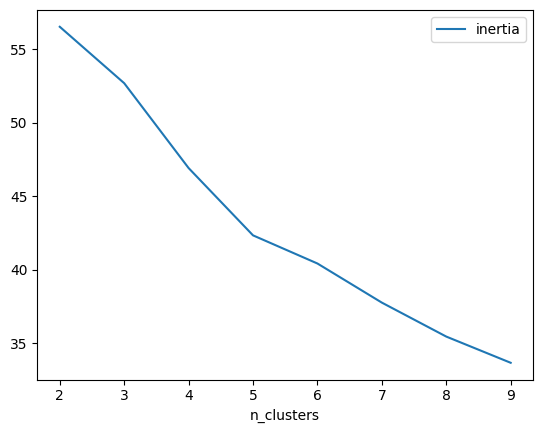

In [9]:
# Inertia
results = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_seasonal_df.drop(columns=["Cluster"]))
    results.append([n_clusters, kmeans.inertia_])
inertia_df = pd.DataFrame(results, columns=["n_clusters", "inertia"]).set_index("n_clusters")
inertia_df.plot()

In [12]:
import calendar
import seaborn as sns

<Axes: >

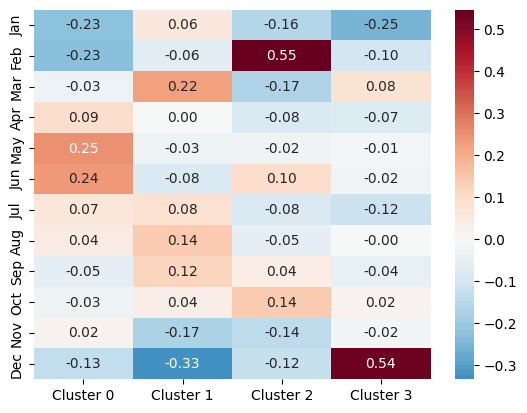

In [13]:
# Cluster visualization
centers = pd.DataFrame(kmeans0.cluster_centers_).transpose()
centers.index = calendar.month_abbr[1:]
centers.columns = [f"Cluster {i}" for i in range(centers.shape[1])]
sns.heatmap(
    centers,
    annot=True,
    fmt=".2f",
    center=0,
    cmap="RdBu_r"
)